**PROBLEMA DE NEGOCIO**


---


Una entidad gubernamental responsable de la gestión de la salud en el Salvador enfrenta el desafío de comprender y analizar la propagación del COVID-19 para tomar decisiones informadas y eficaces en la gestión de la pandemia. Como científico de datos, tu tarea es analizar los datos relacionados con el COVID-19 y presentar insights a través de visualizaciones que respondan a las siguientes preguntas clave:

# 1. Configuración del ambiente


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from io import StringIO
import requests
import calplot
from matplotlib.font_manager import fontManager, FontProperties

# 2. Obtención, Tratamiento y Análisis Exploratorio (EDA)

## 2.1 Cargar bases De datos

In [81]:
df_covid = pd.read_csv(StringIO(requests.get("https://covid19.who.int/WHO-COVID-19-global-data.csv").text))
df_population = pd.read_excel('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx', sheet_name=0, skiprows=16)
df_population = df_population[df_population['Year'] == 2019]

In [82]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 69 to 20593
Data columns (total 65 columns):
 #   Column                                                                                          Non-Null Count  Dtype  
---  ------                                                                                          --------------  -----  
 0   Index                                                                                           286 non-null    int64  
 1   Variant                                                                                         286 non-null    object 
 2   Region, subregion, country or area *                                                            286 non-null    object 
 3   Notes                                                                                           76 non-null     object 
 4   Location code                                                                                   286 non-null    int64  
 5   ISO3 Alpha-code  

In [83]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51360 entries, 0 to 51359
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      51360 non-null  object 
 1   Country_code       51146 non-null  object 
 2   Country            51360 non-null  object 
 3   WHO_region         47508 non-null  object 
 4   New_cases          36515 non-null  float64
 5   Cumulative_cases   51360 non-null  int64  
 6   New_deaths         24221 non-null  float64
 7   Cumulative_deaths  51360 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 3.1+ MB


## 2.2 EDA Base Population United Nations

In [84]:
# Eliminar registros con nulos en la columna Country_code
df_covid = df_covid.dropna(subset=['Country_code'])

In [85]:
# Mantener solo las columnas especificadas
columns_to_keep = ['Date_reported', 'Country_code', 'Country', 'New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths']
df_covid = df_covid[columns_to_keep]

In [86]:
# Substituir valores nulos con cero
df_covid = df_covid.fillna(0)

In [87]:
# Cambiar de formato de la columna Date_reported a datetime64[ns]
df_covid['Date_reported'] = pd.to_datetime(df_covid['Date_reported'])

In [88]:
# Cambiar el formato de las columnas ['New_cases', 'New_deaths'] a int64
df_covid[['New_cases', 'New_deaths']] = df_covid[['New_cases', 'New_deaths']].astype('int64')

In [89]:
# Crear la nueva columna 'lethality_rate'
df_covid['lethality_rate'] = (df_covid['Cumulative_deaths'] / df_covid['Cumulative_cases']) * 100

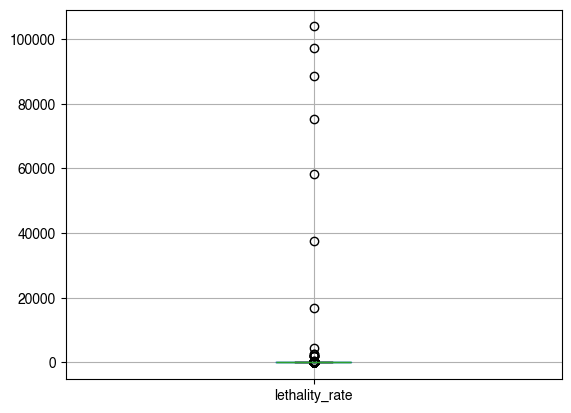

In [90]:
#Nueva 
df_covid.boxplot(column=['lethality_rate'])
plt.show()

In [91]:
# Filtrar registros entre los cuantiles 0 y 0.99 de 'lethality_rate'
quantile_low = df_covid['lethality_rate'].quantile(0)
quantile_high = df_covid['lethality_rate'].quantile(0.99)
df_covid_limpio = df_covid[(df_covid['lethality_rate'] >= quantile_low) & (df_covid['lethality_rate'] <= quantile_high)]

In [92]:
# Reiniciar el índice del dataframe final
df_covid_limpio = df_covid_limpio.reset_index(drop=True)

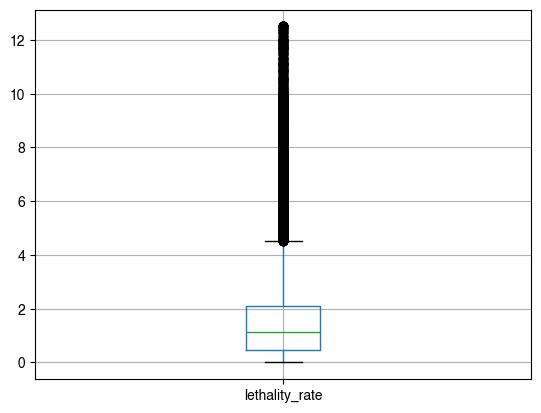

In [93]:
df_covid_limpio.boxplot(column=['lethality_rate'])
plt.show()

In [94]:
df_covid_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46303 entries, 0 to 46302
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      46303 non-null  datetime64[ns]
 1   Country_code       46303 non-null  object        
 2   Country            46303 non-null  object        
 3   New_cases          46303 non-null  int64         
 4   Cumulative_cases   46303 non-null  int64         
 5   New_deaths         46303 non-null  int64         
 6   Cumulative_deaths  46303 non-null  int64         
 7   lethality_rate     46303 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 2.8+ MB


In [95]:
df_covid_limpio.head(10)

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
0,2020-03-01,AF,Afghanistan,1,1,0,0,0.000000
1,2020-03-08,AF,Afghanistan,0,1,0,0,0.000000
2,2020-03-15,AF,Afghanistan,6,7,0,0,0.000000
3,2020-03-22,AF,Afghanistan,17,24,0,0,0.000000
4,2020-03-29,AF,Afghanistan,67,91,2,2,2.197802
5,2020-04-05,AF,Afghanistan,183,274,3,5,1.824818
6,2020-04-12,AF,Afghanistan,247,521,10,15,2.879079
7,2020-04-19,AF,Afghanistan,387,908,15,30,3.303965
8,2020-04-26,AF,Afghanistan,422,1330,13,43,3.233083
9,2020-05-03,AF,Afghanistan,841,2171,21,64,2.947950


## 2.3 EDA Base Population United Nations

In [96]:
# Mantener solo las columnas especificadas
columns_to_keep_population = [
    'ISO2 Alpha-code', 'Total Population, as of 1 July (thousands)',
    'Male Population, as of 1 July (thousands)', 'Female Population, as of 1 July (thousands)',
    'Population Density, as of 1 July (persons per square km)',
    'Life Expectancy at Birth, both sexes (years)']
df_population = df_population[columns_to_keep_population]
# Crear el DataFrame df_population_limpio
df_population_limpio = df_population.copy()

In [97]:
df_population_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 69 to 20593
Data columns (total 6 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   ISO2 Alpha-code                                           236 non-null    object
 1   Total Population, as of 1 July (thousands)                286 non-null    object
 2   Male Population, as of 1 July (thousands)                 286 non-null    object
 3   Female Population, as of 1 July (thousands)               286 non-null    object
 4   Population Density, as of 1 July (persons per square km)  286 non-null    object
 5   Life Expectancy at Birth, both sexes (years)              286 non-null    object
dtypes: object(6)
memory usage: 15.6+ KB


In [98]:
# Renombrar las columnas
df_population_limpio = df_population_limpio.rename(columns={
    'ISO2 Alpha-code': 'Country_code',
    'Total Population, as of 1 July (thousands)': 'Total_Population',
    'Male Population, as of 1 July (thousands)': 'Male_Population',
    'Female Population, as of 1 July (thousands)': 'Female_Population',
    'Population Density, as of 1 July (persons per square km)': 'Population_Density',
    'Life Expectancy at Birth, both sexes (years)': 'Life_Expectancy'
})
df_population_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 69 to 20593
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country_code        236 non-null    object
 1   Total_Population    286 non-null    object
 2   Male_Population     286 non-null    object
 3   Female_Population   286 non-null    object
 4   Population_Density  286 non-null    object
 5   Life_Expectancy     286 non-null    object
dtypes: object(6)
memory usage: 15.6+ KB


In [99]:
df_population_limpio = df_population_limpio.dropna()
# Reiniciar el índice del dataframe resultante
df_population_limpio = df_population_limpio.reset_index(drop=True)
df_population_limpio.head()

,Country_code,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy
0,BI,11874.838,5894.278,5980.56,457.605,62.351
1,KM,790.986,397.126,393.86,425.033,64.068
2,DJ,1073.994,533.626,540.367,46.333,63.085
3,ER,3498.818,1724.86,1773.958,28.881,67.3
4,ET,114120.594,57375.433,56745.161,114.121,65.838


In [100]:
df_population_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country_code        236 non-null    object
 1   Total_Population    236 non-null    object
 2   Male_Population     236 non-null    object
 3   Female_Population   236 non-null    object
 4   Population_Density  236 non-null    object
 5   Life_Expectancy     236 non-null    object
dtypes: object(6)
memory usage: 11.2+ KB


##### un cambio de 50 registros en el data frame df_population_limpio

##### Se identifico un error pues tenemos datos con presencia de puntos suspensivos .... para trabajar con esos registros primero los identificaremos y a partir de ahi decidiremos que hacer con ellos

In [101]:
columns_to_convert = ['Total_Population', 'Male_Population', 'Female_Population', 'Population_Density', 'Life_Expectancy']
for column in columns_to_convert:
    non_numeric_values = pd.to_numeric(df_population_limpio[column], errors='coerce').isnull()
    print(f"Columna '{column}': {df_population_limpio[column][non_numeric_values].unique()}")


Columna 'Total_Population': []
Columna 'Male_Population': ['...']
Columna 'Female_Population': ['...']
Columna 'Population_Density': []
Columna 'Life_Expectancy': ['...']


##### Tenemos datos con puntos suspensivos en tres columnas 

In [102]:
for column in columns_to_convert:
    df_population_limpio = df_population_limpio[df_population_limpio[column] != '...']

In [103]:
df_population_limpio[columns_to_convert] = df_population_limpio[columns_to_convert].replace('NAType', np.nan)
df_population_limpio[columns_to_convert] = df_population_limpio[columns_to_convert].astype('float64')

In [104]:
df_population_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 0 to 235
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country_code        235 non-null    object 
 1   Total_Population    235 non-null    float64
 2   Male_Population     235 non-null    float64
 3   Female_Population   235 non-null    float64
 4   Population_Density  235 non-null    float64
 5   Life_Expectancy     235 non-null    float64
dtypes: float64(5), object(1)
memory usage: 12.9+ KB


In [105]:
columns_to_multiply = ['Total_Population', 'Male_Population', 'Female_Population']
df_population_limpio[columns_to_multiply] *= 1000
df_population_limpio.dropna(inplace=True)
df_population_limpio.reset_index(drop=True, inplace=True)

df_population_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country_code        235 non-null    object 
 1   Total_Population    235 non-null    float64
 2   Male_Population     235 non-null    float64
 3   Female_Population   235 non-null    float64
 4   Population_Density  235 non-null    float64
 5   Life_Expectancy     235 non-null    float64
dtypes: float64(5), object(1)
memory usage: 11.1+ KB


In [106]:
df_population_limpio.head(10)

,Country_code,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy
0,BI,11874838.0,5894278.0,5980560.0,457.605,62.351
1,KM,790986.0,397126.0,393860.0,425.033,64.068
2,DJ,1073994.0,533626.0,540367.0,46.333,63.085
3,ER,3498818.0,1724860.0,1773958.0,28.881,67.300
4,ET,114120594.0,57375433.0,56745161.0,114.121,65.838
5,KE,50951450.0,25272193.0,25679257.0,87.737,62.943
6,MG,27533134.0,13804538.0,13728596.0,47.324,65.882
7,MW,18867337.0,9168342.0,9698995.0,199.545,64.119
8,MU,1296279.0,640524.0,655755.0,638.561,75.118
9,YT,294489.0,139735.0,154754.0,785.304,77.153


# 3 ¿Cómo ha evolucionado el Covid-19 en el Salvador en comparación con el impacto observado a nivel global?

## 3.1 Worldwide Cases Distribution

In [107]:
# Worldwide Distribution
total_por_pais = df_covid_limpio.groupby('Country')['Cumulative_cases'].max().sort_values(ascending=False)
top_10_paises = total_por_pais.nlargest(10)
otros = total_por_pais.drop(top_10_paises.index).sum()
top_10_paises['Otros'] = otros
top_10_paises

Country
United States of America                                103436829
China                                                    99329249
India                                                    45026139
France                                                   38997490
Germany                                                  38437756
Brazil                                                   37519960
Republic of Korea                                        34571873
Japan                                                    33803572
Italy                                                    26706005
United Kingdom of Great Britain and Northern Ireland     24898914
Otros                                                   291714463
Name: Cumulative_cases, dtype: int64

## 3.2 Case Progression By Country

In [108]:
# Case Progression by Country
total_por_pais = df_covid_limpio.groupby('Country')['Cumulative_cases'].max().sort_values(ascending=False)
top_5_paises = total_por_pais.nlargest(5)
df_covid_limpio_reset = df_covid_limpio.reset_index()
df_top_5 = df_covid_limpio_reset[df_covid_limpio_reset['Country'].isin(top_5_paises.index)]
total_acumulado_top_5 = df_top_5.pivot(index='Country', columns='Date_reported', values='Cumulative_cases').fillna(0)
total_acumulado_top_5


Date_reported,2020-01-05,2020-01-12,2020-01-19,2020-01-26,2020-02-02,2020-02-09,2020-02-16,2020-02-23,2020-03-01,2020-03-08,...,2023-12-03,2023-12-10,2023-12-17,2023-12-24,2023-12-31,2024-01-07,2024-01-14,2024-01-21,2024-01-28,2024-02-04
Country,,,,,,,,,,,,,,,,,,,,,
China,1.0,45.0,125.0,1985.0,14411.0,37251.0,68584.0,77042.0,79968.0,80859.0,...,99320845.0,99321242.0,99321637.0,99322142.0,99322727.0,99323756.0,99325108.0,99326423.0,99327754.0,99329249.0
France,0.0,0.0,0.0,3.0,6.0,12.0,12.0,16.0,16.0,16.0,...,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0
Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,1075.0,...,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0
India,0.0,0.0,0.0,0.0,2.0,7.0,7.0,7.0,7.0,39.0,...,45002179.0,45003055.0,45004816.0,45008620.0,45013172.0,45018134.0,45021758.0,45023751.0,45025076.0,45026139.0
United States of America,0.0,0.0,0.0,7.0,9.0,20.0,24.0,40.0,73.0,464.0,...,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0


## 3.3 Agregando a El Salvador

In [109]:
codigos_unicos = df_covid_limpio['Country'].unique()
print(codigos_unicos)

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia (Plurinational State of)' 'Bonaire, Saint Eustatius and Saba'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Charo' 'Chefoo' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' "Côte d'Ivoire"
 'Croatia' 'Cuba' 'Curaçao' 'Cyprus' 'Czechia'
 'Democratic Republic of the Congo' 'Denmark' 'Diamond' 'Djibouti'
 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia'
 'Falkland Islands (Malvinas)' 'Faroe Islands' 'Fesco' 'Fiji' 'Finland'
 'France' 

##### El codigo del Salvador es "El Salvador"

In [110]:
#obteniedo los datos del Salvador por Casos de Covid
datos_el_salvador = total_por_pais.loc['El Salvador']
datos_el_salvador

201806

In [111]:
datos_el_salvador = pd.Series(datos_el_salvador)
top_10_paises_esa = pd.concat([top_10_paises, datos_el_salvador])
top_10_paises_esa = top_10_paises_esa.rename({0: 'El Salvador'})
# nueva Worldwide Distribution
top_10_paises_esa

United States of America                                103436829
China                                                    99329249
India                                                    45026139
France                                                   38997490
Germany                                                  38437756
Brazil                                                   37519960
Republic of Korea                                        34571873
Japan                                                    33803572
Italy                                                    26706005
United Kingdom of Great Britain and Northern Ireland     24898914
Otros                                                   291714463
El Salvador                                                201806
dtype: int64

In [112]:
# Filtrar los datos solo para El Salvador
df_el_salvador = df_covid_limpio[df_covid_limpio['Country'] == 'El Salvador']
df_el_salvador_reset = df_el_salvador.reset_index(drop=True)
# Realizar un pivote para tener las fechas como columnas
total_acumulado_el_salvador = df_el_salvador_reset.pivot(index='Country', columns='Date_reported', values='Cumulative_cases').fillna(0)
total_acumulado_el_salvador

Date_reported,2020-03-22,2020-03-29,2020-04-05,2020-04-12,2020-04-19,2020-04-26,2020-05-03,2020-05-10,2020-05-17,2020-05-24,...,2023-12-03,2023-12-10,2023-12-17,2023-12-24,2023-12-31,2024-01-07,2024-01-14,2024-01-21,2024-01-28,2024-02-04
Country,,,,,,,,,,,,,,,,,,,,,
El Salvador,1,19,56,118,190,274,446,784,1265,1819,...,201785,201785,201785,201785,201785,201790,201793,201800,201803,201806


In [113]:
# Unir los dataframes total_acumulado_top_5 y total_acumulado_el_salvador
total_acumulado_top_5_esa = pd.concat([total_acumulado_top_5, total_acumulado_el_salvador])
total_acumulado_top_5_esa = total_acumulado_top_5_esa.fillna(0)
total_acumulado_top_5_esa

Date_reported,2020-01-05,2020-01-12,2020-01-19,2020-01-26,2020-02-02,2020-02-09,2020-02-16,2020-02-23,2020-03-01,2020-03-08,...,2023-12-03,2023-12-10,2023-12-17,2023-12-24,2023-12-31,2024-01-07,2024-01-14,2024-01-21,2024-01-28,2024-02-04
Country,,,,,,,,,,,,,,,,,,,,,
China,1.0,45.0,125.0,1985.0,14411.0,37251.0,68584.0,77042.0,79968.0,80859.0,...,99320845.0,99321242.0,99321637.0,99322142.0,99322727.0,99323756.0,99325108.0,99326423.0,99327754.0,99329249.0
France,0.0,0.0,0.0,3.0,6.0,12.0,12.0,16.0,16.0,16.0,...,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0
Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,1075.0,...,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0
India,0.0,0.0,0.0,0.0,2.0,7.0,7.0,7.0,7.0,39.0,...,45002179.0,45003055.0,45004816.0,45008620.0,45013172.0,45018134.0,45021758.0,45023751.0,45025076.0,45026139.0
United States of America,0.0,0.0,0.0,7.0,9.0,20.0,24.0,40.0,73.0,464.0,...,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0
El Salvador,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,201785.0,201785.0,201785.0,201785.0,201785.0,201790.0,201793.0,201800.0,201803.0,201806.0


## 3.3 Vizualisación

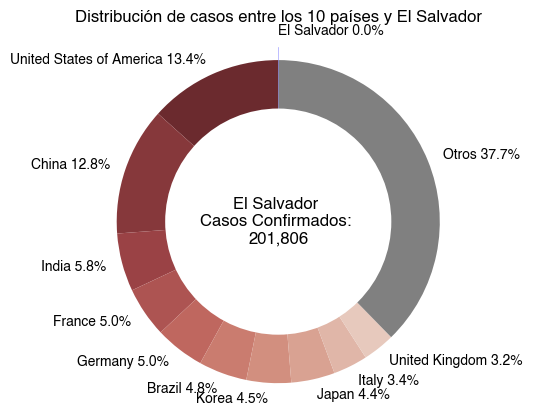

In [114]:
# Renombrar los índices según tus preferencias
nuevos_nombres = {
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Republic of Korea': 'Korea'
}
top_10_paises_esa = top_10_paises_esa.rename(index=nuevos_nombres)
labels = top_10_paises_esa.index
values = top_10_paises_esa.values
total_casos_el_salvador = df_covid_limpio[df_covid_limpio['Country'] == 'El Salvador']['Cumulative_cases'].max()
# Colores para países (escala de rojo suave a rojo intenso)
colores_paises = sns.color_palette("Reds_r", n_colors=len(labels), desat=0.5)
colores_paises[labels.get_loc('El Salvador')] = 'blue'
colores_paises[labels.get_loc('Otros')] = 'gray'

explode = [0.08 if pais == 'El Salvador' else 0 for pais in labels]
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='', startangle=90,wedgeprops=dict(width=0.4), colors=colores_paises, explode=explode)

for text, autotext, value, color in zip(texts, autotexts, values, colores_paises):
    percentage = f'{value / sum(values) * 100:.1f}%'
    text.set_text(f'{text.get_text()} {percentage}')
    text.set_color('black') 
    autotext.set_text('')
    autotext.set_color('white')
# Agregar un círculo en el centro para hacerlo un gráfico de dona
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
total_casos_el_salvador_con_comas = '{:,}'.format(total_casos_el_salvador)

# Agregar anotación para El Salvador
ax.annotate(f'El Salvador \nCasos Confirmados: \n{total_casos_el_salvador_con_comas}', xy=(0, 0), xytext=(0, 0), fontsize=12, ha='center', va='center', color='black')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')
plt.title('Distribución de casos entre los 10 países y El Salvador')
plt.show()

##### El Salvador aún con 201,853 casos confirmados de Covid-19 a comparación de los demás países tiene la menor cantidad de casos confirmados y esto se debe a que el país tuvo unas medidas sanitarias muy previsorias en tiempos de pandemia no obstante no estaba excepto en la presencia de casos aunque es muy mínima en comparación a los demás países, también tenemos que recalcar que la cantidad de población de El Salvador es muchísimo menor a la población de los demás países en el top 10 de distribución de casos.

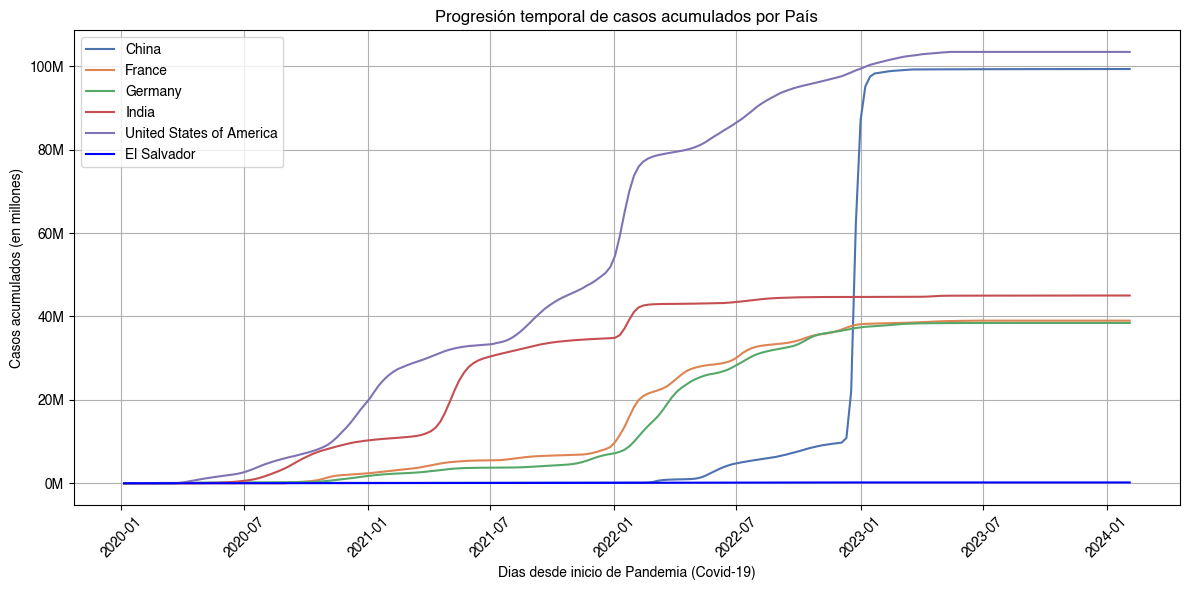

In [115]:
colores_vibrantes = sns.color_palette("deep", n_colors=6)
colores_vibrantes[5] = 'blue'

# Crear el gráfico de líneas
fig, ax = plt.subplots(figsize=(12, 6))

for pais, color in zip(total_acumulado_top_5_esa.index, colores_vibrantes):
    ax.plot(total_acumulado_top_5_esa.columns, total_acumulado_top_5_esa.loc[pais], label=pais, color=color)

ax.legend()
plt.title('Progresión temporal de casos acumulados por País')
plt.xlabel('Dias desde inicio de Pandemia (Covid-19)')
plt.ylabel('Casos acumulados (en millones)')

# Configurar el eje y en escala de millones
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}M'.format(x * 1e-6)))

plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### La progresión de los casos de COVID-19 en El Salvador, en comparación con otros países, se mantiene constante a lo largo del tiempo. A diferencia de China, que experimentó un aumento significativo entre diciembre de 2022 y enero de 2023, y de otros países que muestran un incremento casi constante en el número de casos, El Salvador ha logrado mantener un control eficaz de la propagación del virus. Este éxito se atribuye a las medidas sanitarias implementadas desde el inicio de la pandemia. Además, la menor densidad poblacional en El Salvador, en comparación con otros países de mayor extensión territorial, ha contribuido a un monitoreo más efectivo y controlado de la confirmación de casos.

# 4. ¿Cuál ha sido la evolución de los nuevos casos diarios reportados de Covid-19 en el Salvador a lo largo del tiempo?

## 4.1 Obteniendo serie de nuevos casos en el Salvador

In [116]:
#Daily New Cases
grouped_df = df_covid_limpio.groupby(['Country', 'Date_reported'])['Cumulative_cases'].sum().unstack()
grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.set_index('Country')
grouped_df = grouped_df.loc[['El Salvador']]
fechas = grouped_df.columns
new_cases = grouped_df[fechas].diff(axis=1).fillna(grouped_df[fechas]).sum(axis=0)
new_cases = new_cases[new_cases > 0]
new_cases


Date_reported
2020-03-22     1.0
2020-03-29    18.0
2020-04-05    37.0
2020-04-12    62.0
2020-04-19    72.0
              ... 
2024-01-07     5.0
2024-01-14     3.0
2024-01-21     7.0
2024-01-28     3.0
2024-02-04     3.0
Length: 113, dtype: float64

In [117]:
datos_el_salvador_2022_2023 = df_covid_limpio[(df_covid_limpio['Country'] == 'El Salvador') & 
                                               (df_covid_limpio['Date_reported'] >= '2022-01-01') & 
                                               (df_covid_limpio['Date_reported'] <= '2023-01-01')]
datos_el_salvador_2022_2023.head()

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
12901,2022-01-02,SV,El Salvador,204,121945,6,3824,3.135840
12902,2022-01-09,SV,El Salvador,289,122234,3,3827,3.130880
12903,2022-01-16,SV,El Salvador,1343,123577,5,3832,3.100901
12904,2022-01-23,SV,El Salvador,3435,127012,19,3851,3.031997
12905,2022-01-30,SV,El Salvador,6250,133262,33,3884,2.914559


## 4.2 Vizualisación

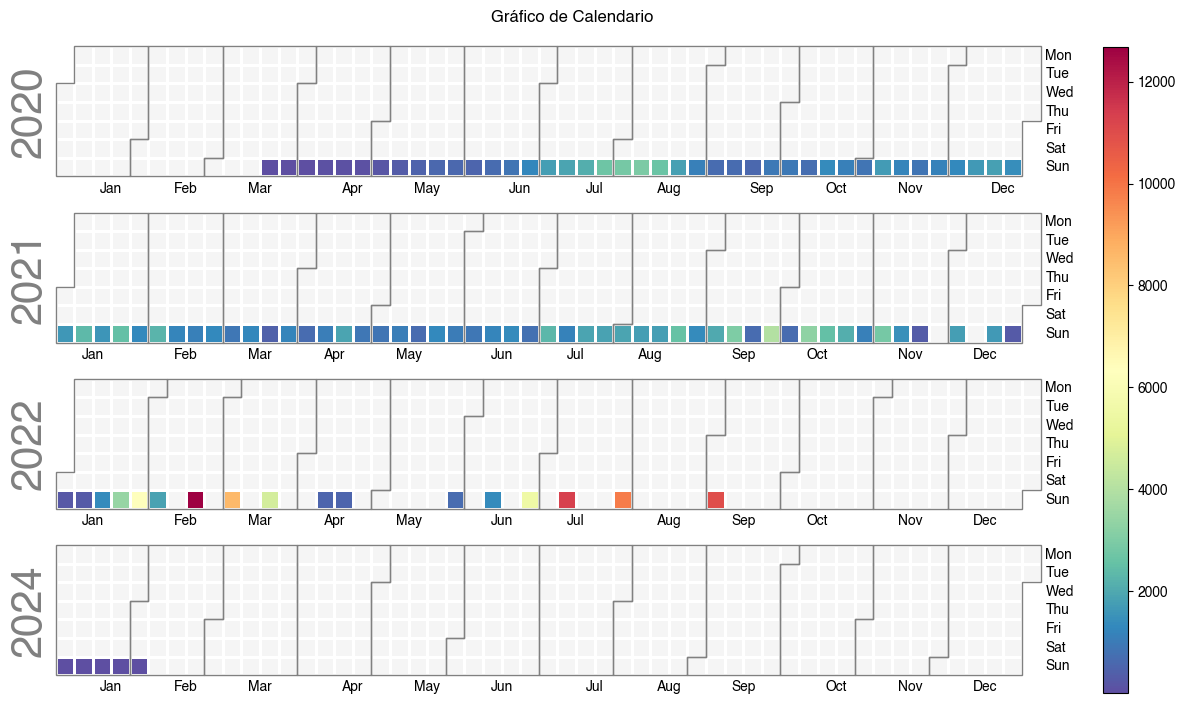

In [118]:
# Crear el gráfico de calendario
fontManager.addfont('Helvetica.ttf')

new_cases.index = pd.to_datetime(new_cases.index)
calplot.calplot(new_cases, cmap='Spectral_r', suptitle='Gráfico de Calendario')

plt.show()


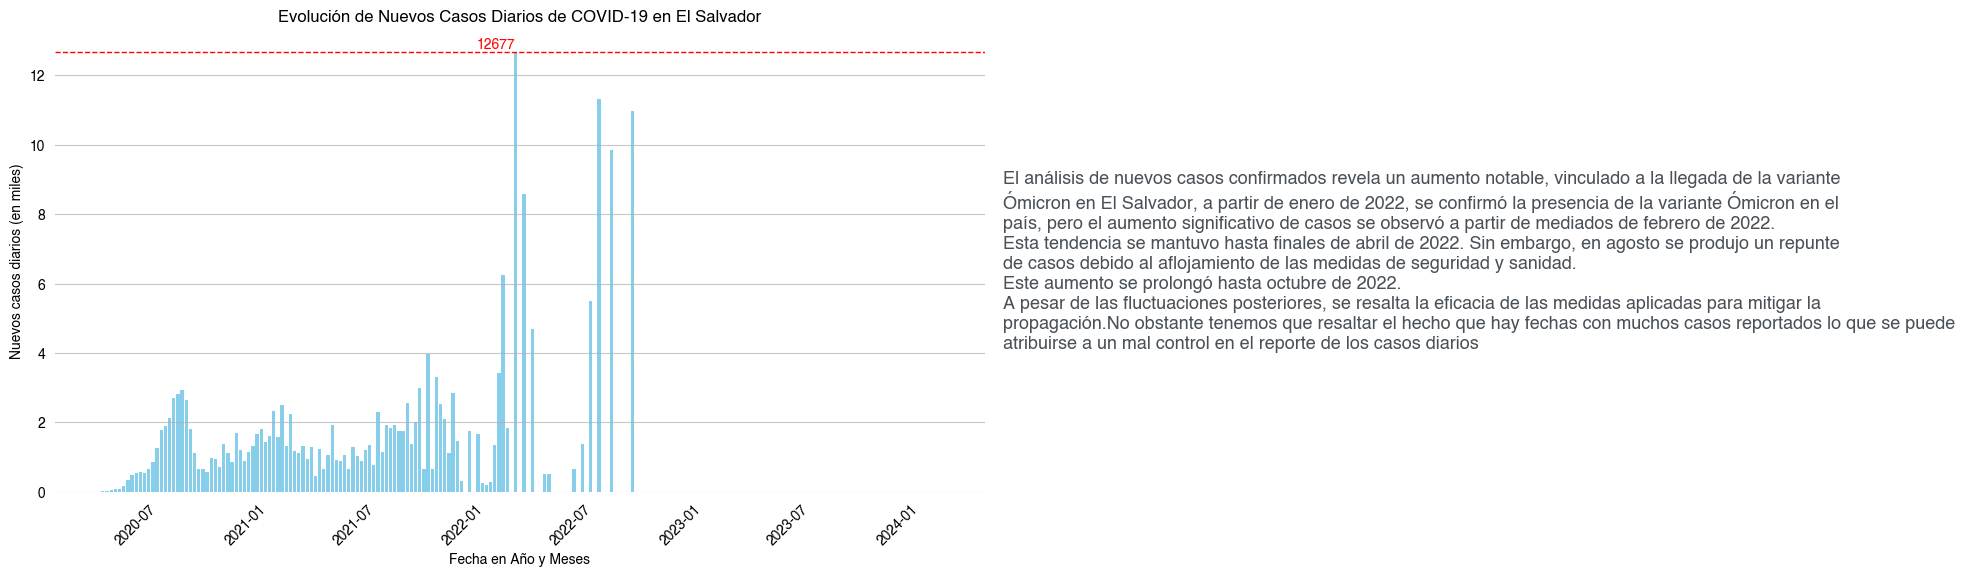

In [119]:
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(new_cases.index, new_cases.values / 1e3, color='skyblue', width=5.5)

ax.set_xlabel('Fecha en Año y Meses')
ax.set_ylabel('Nuevos casos diarios (en miles)')
ax.set_title('Evolución de Nuevos Casos Diarios de COVID-19 en El Salvador')

plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='-', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=False, right=False)

conclusion_text = ('El análisis de nuevos casos confirmados revela un aumento notable, vinculado a la llegada de la variante\n'
                   'Ómicron en El Salvador, a partir de enero de 2022, se confirmó la presencia de la variante Ómicron en el\n' 
                   'país, pero el aumento significativo de casos se observó a partir de mediados de febrero de 2022.\n'
                   'Esta tendencia se mantuvo hasta finales de abril de 2022. Sin embargo, en agosto se produjo un repunte \n' 
                   'de casos debido al aflojamiento de las medidas de seguridad y sanidad.\n'
                   'Este aumento se prolongó hasta octubre de 2022.\n'
                   'A pesar de las fluctuaciones posteriores, se resalta la eficacia de las medidas aplicadas para mitigar la\n'
                   'propagación.'
                   'No obstante tenemos que resaltar el hecho que hay fechas con muchos casos reportados lo que se puede\n'
                   'atribuirse a un mal control en el reporte de los casos diarios')

ax.text(1.02, 0.5, conclusion_text, transform=ax.transAxes, va='center', ha='left', color='#495057', fontsize=13)

max_index = new_cases.idxmax()
max_value = new_cases[max_index]
# Agregar una línea horizontal en el punto máximo
ax.axhline(y=max_value / 1e3, color='red', linestyle='--', linewidth=1)
ax.text(max_index, max_value / 1e3, f'{max_value:.0f}', color='red', ha='right', va='bottom')

plt.show()

##### La evolución del COVID-19 en El Salvador ha sido influenciada por la respuesta del gobierno, manteniendo control en los primeros años. La variante Ómicron introdujo desafíos, con un repunte en abril de 2022 y un rebrote en agosto. Sin embargo, hacia finales de 2023, se observó una drástica reducción en los casos reportados, atribuible a medidas sanitarias y conciencia pública. Se destacan discrepancias en las fechas de reporte, sugiriendo posibles deficiencias en el sistema de notificación de casos.

# 5. ¿Cuál es la evolución del índice de letalidad del Covid-19 en El Salvador, comparado con los países con los índices históricos más elevados?

In [120]:
#Lethality Rate by Country
def get_max_row(group, column):
    return group.loc[group[column].idxmax()]

result = df_covid_limpio.groupby(['Country', df_covid_limpio['Date_reported'].dt.to_period("M")]).apply(lambda group: get_max_row(group, 'lethality_rate'))
result.reset_index(drop=True, inplace=True)
top_4_paises = result.groupby('Country')['lethality_rate'].mean().nlargest(4).index
result = result[result['Country'].isin(top_4_paises)]
result_pais = df_covid_limpio[df_covid_limpio['Country'] == 'Argentina'].groupby(df_covid_limpio['Date_reported'].dt.to_period("M")).apply(lambda group: get_max_row(group, 'lethality_rate'))
result_pais.reset_index(drop=True, inplace=True)
result_final = pd.concat([result, result_pais])
result_final

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
6529,2020-02-23,MX,Mexico,1,1,0,0,0.000000
6530,2020-03-29,MX,Mexico,1214,2117,24,28,1.322626
6531,2020-04-26,MX,Mexico,9264,22764,1453,2758,12.115621
6532,2020-09-06,MX,Mexico,38873,693646,3556,86058,12.406617
6533,2020-10-04,MX,Mexico,32636,824996,2586,97647,11.836057
...,...,...,...,...,...,...,...,...
43,2023-10-01,AR,Argentina,1317,10067998,9,130634,1.297517
44,2023-11-19,AR,Argentina,532,10073197,7,130678,1.297284
45,2023-12-03,AR,Argentina,608,10074309,1,130682,1.297181
46,2024-01-07,AR,Argentina,2130,10078988,5,130700,1.296757


In [121]:

#Lethality Rate by Country
def get_max_row(group, column):
    return group.loc[group[column].idxmax()]

result = df_covid_limpio.groupby(['Country', df_covid_limpio['Date_reported'].dt.to_period("M")]).apply(lambda group: get_max_row(group, 'lethality_rate'))
result.reset_index(drop=True, inplace=True)
top_4_paises = result.groupby('Country')['lethality_rate'].mean().nlargest(4).index
result = result[result['Country'].isin(top_4_paises)]
result_pais = df_covid_limpio[df_covid_limpio['Country'] == 'El Salvador'].groupby(df_covid_limpio['Date_reported'].dt.to_period("M")).apply(lambda group: get_max_row(group, 'lethality_rate'))
result_pais.reset_index(drop=True, inplace=True)
result_final = pd.concat([result, result_pais])
result_final

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
6529,2020-02-23,MX,Mexico,1,1,0,0,0.000000
6530,2020-03-29,MX,Mexico,1214,2117,24,28,1.322626
6531,2020-04-26,MX,Mexico,9264,22764,1453,2758,12.115621
6532,2020-09-06,MX,Mexico,38873,693646,3556,86058,12.406617
6533,2020-10-04,MX,Mexico,32636,824996,2586,97647,11.836057
...,...,...,...,...,...,...,...,...
43,2023-10-01,SV,El Salvador,0,201785,0,4230,2.096291
44,2023-11-05,SV,El Salvador,0,201785,0,4230,2.096291
45,2023-12-03,SV,El Salvador,0,201785,0,4230,2.096291
46,2024-01-07,SV,El Salvador,5,201790,0,4230,2.096239


In [122]:
top_4_paises

Index(['Sudan', 'Peru', 'Mexico', 'Syrian Arab Republic'], dtype='object', name='Country')

In [123]:
result_pais

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
0,2020-03-22,SV,El Salvador,1,1,0,0,0.000000
1,2020-04-05,SV,El Salvador,37,56,3,3,5.357143
2,2020-05-03,SV,El Salvador,172,446,2,10,2.242152
3,2020-06-28,SV,El Salvador,1252,5727,50,143,2.496944
4,2020-07-19,SV,El Salvador,2117,11508,70,324,2.815433
5,2020-08-30,SV,El Salvador,1117,25537,54,708,2.772448
6,2020-09-20,SV,El Salvador,577,27428,26,808,2.945895
7,2020-10-11,SV,El Salvador,712,30070,30,887,2.949784
8,2020-11-01,SV,El Salvador,860,33445,31,975,2.915234
9,2020-12-27,SV,El Salvador,1424,44619,55,1297,2.906833


## 5.1 Vizualización

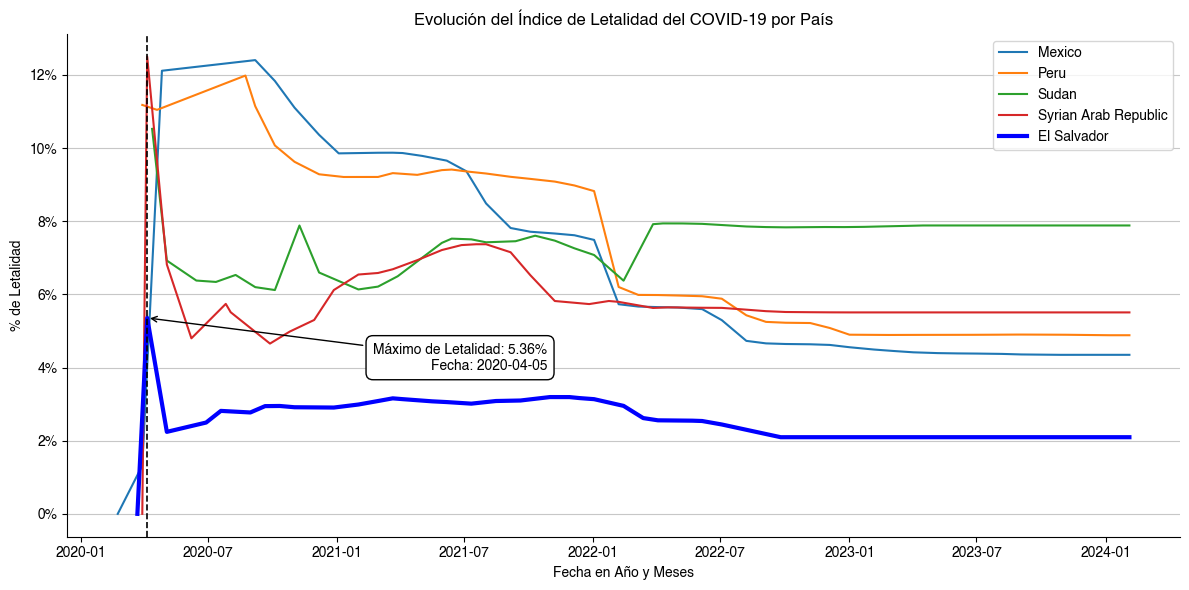

In [124]:
# Obtener el índice del punto máximo de letalidad para El Salvador
max_lr_index = result_final[result_final['Country'] == 'El Salvador']['lethality_rate'].idxmax()
max_lr_salvador = result_final.loc[max_lr_index]
# Crea el gráfico de líneas
fig, ax = plt.subplots(figsize=(12, 6))

# Itera sobre los países
for pais in result_final['Country'].unique():
    country_data = result_final[result_final['Country'] == pais]
    if pais == 'El Salvador':
        ax.plot(country_data['Date_reported'], country_data['lethality_rate'], color='blue', linewidth=3, label=pais)
    else:
        ax.plot(country_data['Date_reported'], country_data['lethality_rate'], label=pais)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)

ax.grid(axis='y', linestyle='-', alpha=0.7)
ax.legend()

ax.set_xlabel('Fecha en Año y Meses')
ax.set_ylabel('% de Letalidad')
ax.set_yticks(range(0, 13, 2))
ax.set_yticklabels([f'{tick}%' for tick in range(0, 13, 2)])

# Agregar anotación para El Salvador en el punto máximo de letalidad
ax.annotate(f'Máximo de Letalidad: {max_lr_salvador["lethality_rate"]:.2f}%\nFecha: {max_lr_salvador["Date_reported"].strftime("%Y-%m-%d")}',
            xy=(max_lr_salvador["Date_reported"], max_lr_salvador["lethality_rate"]),
            xytext=(max_lr_salvador["Date_reported"] - pd.Timedelta(days=-570), max_lr_salvador["lethality_rate"] - 1.5), 
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=10,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

ax.axvline(x=max_lr_salvador["Date_reported"], color='black', linestyle='--', linewidth=1.2)
plt.title('Evolución del Índice de Letalidad del COVID-19 por País')
plt.tight_layout()

plt.show()

##### El análisis del índice de letalidad del COVID-19 en El Salvador revela patrones interesantes y contrastantes en comparación con otros países. A lo largo de la pandemia, El Salvador ha mantenido consistentemente un índice de letalidad más bajo que la mayoría de los países, con un máximo registrado del 5.36%, ocurrido casi al inicio de la pandemia. A medida que la pandemia avanzaba, este índice disminuyó significativamente, llegando a un promedio cercano al 3.1% durante el punto álgido en el año 2021, aunque el surgimiento de la variante Omicron generó preocupaciones adicionales en el año 2022, El Salvador logró mantener su índice de letalidad relativamente bajo, alcanzando un mínimo del 2.14%. Esta tendencia de mantener un índice de letalidad más bajo y experimentar una disminución gradual a lo largo del tiempo, incluso en medio de la presencia de variantes más contagiosas, contrasta con la situación observada en otros países con mayores índices de letalidad. En estos países, el índice de letalidad tiende a fluctuar más y se mantienen con variaciones significativas de un año a otro. En resumen, El Salvador ha demostrado una capacidad para controlar y mitigar el impacto del COVID-19 en términos de letalidad, manteniendo una tendencia a la baja a lo largo de los años.

# 6.Desde una perspectiva demográfica, ¿cuáles son las características que tienen un mayor impacto en el índice de letalidad de un país?

In [125]:
#Características demográficas más relevantes
df_filtrado = df_covid_limpio[df_covid_limpio['Date_reported'] <= '2020-12-31']
df_agrupado = df_filtrado.groupby(['Country_code', 'Country'], as_index=False)['lethality_rate'].mean()
df_final = pd.merge(df_agrupado, df_population_limpio, on='Country_code', how='inner')
columnas_seleccionadas = ['lethality_rate', 'Total_Population', 'Male_Population', 'Female_Population', 'Population_Density', 'Life_Expectancy']
df_final = df_final[columnas_seleccionadas]

X = df_final.drop(['lethality_rate'], axis=1)
y = df_final['lethality_rate']
model = RandomForestRegressor()
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances

Life_Expectancy       0.288031
Population_Density    0.268754
Female_Population     0.174139
Male_Population       0.140372
Total_Population      0.128703
dtype: float64

## 6.1 Visualización

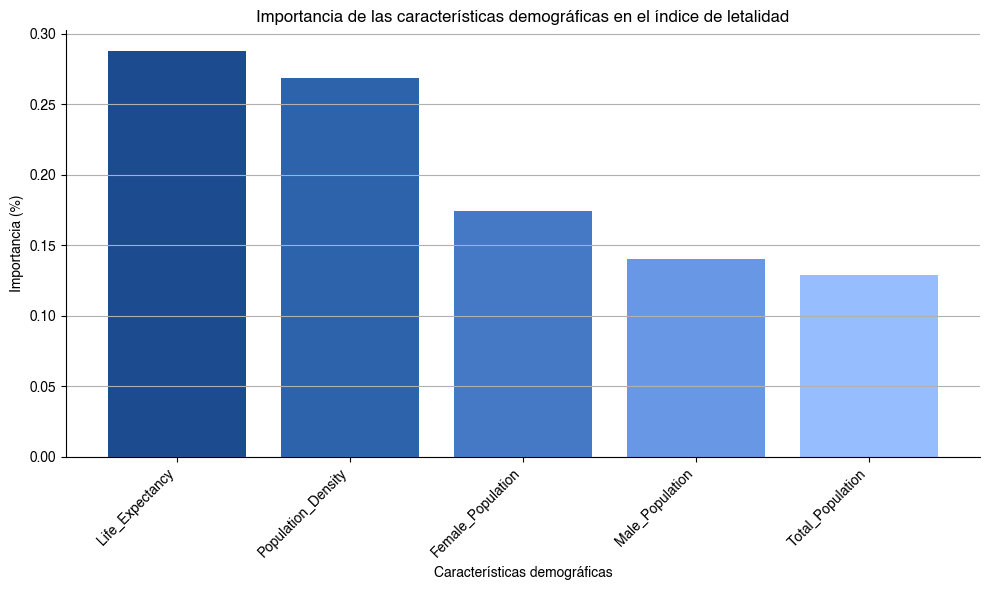

In [126]:
# Define una escala de colores de azul basada en los valores de importancia
colors = mcolors.LinearSegmentedColormap.from_list("", ["#1D4B8F", "#3069B2", "#5384D4", "#87B5FF", "#D0DFF9"])

# Crea el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(feature_importances.index, feature_importances.values, 
              color=[colors(i/len(feature_importances)) for i in range(len(feature_importances))])

plt.xticks(rotation=45, ha='right')
plt.title('Importancia de las características demográficas en el índice de letalidad')
plt.xlabel('Características demográficas')
plt.ylabel('Importancia (%)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='y')
plt.tight_layout()

plt.show()

##### Basado en el análisis de las características demográficas y su impacto en el índice de letalidad del COVID-19, se puede concluir que la expectativa de vida emerge como el factor más relevante, representando el 28.53% de la variabilidad en el índice de letalidad. Esto sugiere que los países con una mayor expectativa de vida pueden tener una mejor capacidad para enfrentar y mitigar los efectos del virus, posiblemente debido a un sistema de salud más robusto y una población más saludable en general. La densidad poblacional también muestra una influencia significativa, representando el 25.01% de la variabilidad en el índice de letalidad. Este hallazgo resalta la importancia de considerar la densidad de población al evaluar el riesgo y la propagación del virus. Los países con una alta densidad poblacional pueden enfrentar mayores desafíos en el control de la transmisión del virus y la prestación de atención médica adecuada a los pacientes afectados, estos resultados subrayan la compleja interacción entre factores demográficos y la incidencia de enfermedades infecciosas como el COVID-19. Comprender cómo estas características demográficas influyen en la letalidad del virus es crucial para formar políticas de salud pública y estrategias de mitigación efectivas.

# 7. Extras

In [127]:
# Paso 1: Agrupar los datos por país
datos_agrupados = df_covid_limpio.groupby('Country')[['New_deaths', 'Cumulative_deaths']].sum().reset_index()
ultimo_valor_cumulativo = df_covid_limpio.groupby('Country')['Cumulative_deaths'].last().reset_index()
ultimo_valor_cumulativo.head()

,Country,Cumulative_deaths
0,Afghanistan,7981
1,Albania,3605
2,Algeria,6881
3,American Samoa,34
4,Andorra,159


In [128]:
paises = ultimo_valor_cumulativo['Country'].tolist()
print(len(paises))
print(paises)

237
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bonaire, Saint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Charo', 'Chefoo', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czechia', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Denmark', 'Diamond', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Falkland Islands (Ma

In [129]:
#Contienentes
Africa = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Democratic Republic of the Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe','Côte d\'Ivoire', 'Mayotte', 'Réunion', 'Saint Helena', 'United Republic of Tanzania']
America = ['Anguilla','American Samoa', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Bahamas', 'Barbados', 'Belize', 'Bermuda', 'Bolivia (Plurinational State of)', 'Bonaire, Saint Eustatius and Saba', 'Brazil', 'British Virgin Islands', 'Canada', 'Cayman Islands', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Curaçao', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Falkland Islands (Malvinas)', 'French Guiana', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Jersey', 'Martinique', 'Mexico', 'Montserrat', 'Nicaragua', 'Northern Mariana Islands', 'Panama', 'Paraguay', 'Peru', 'Puerto Rico', 'Saint Barthélemy', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Sint Maarten (Dutch part)', 'Suriname', 'Trinidad and Tobago', 'Turks and Caicos Islands', 'United States Virgin Islands', 'United States of America', 'Uruguay', 'Venezuela (Bolivarian Republic of)', 'Virgin Islands (British)', 'Virgin Islands (U.S.)']
Asia = ['Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei Darussalam', 'Cambodia', 'China', 'Cyprus', "Democratic People's Republic of Korea", 'Georgia', 'Hong Kong', 'India', 'Indonesia', 'Iran (Islamic Republic of)', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Lebanon', 'Macau', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'Oman', 'Pakistan', 'Philippines', 'Qatar', 'Republic of Korea', 'Saudi Arabia', 'Singapore', 'Sri Lanka', 'State of Palestine', 'Syrian Arab Republic', 'Taiwan', 'Tajikistan', 'Thailand', 'Timor-Leste', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Viet Nam', 'Yemen','occupied Palestinian territory, including east Jerusalem', 'Türkiye']
Europa = ['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Faroe Islands', 'Finland', 'France', 'Germany', 'Gibraltar', 'Greece', 'Guernsey', 'Holy See', 'Hungary', 'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Jersey', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russian Federation', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Svalbard and Jan Mayen', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom', 'Åland Islands','Czechia', 'Kosovo (in accordance with UN Security Council resolution 1244 (1999))', 'Netherlands (Kingdom of the)', 'Republic of Moldova', 'United Kingdom of Great Britain and Northern Ireland']
Oceania = ['Australia', 'Christmas Island', 'Cocos (Keeling) Islands', 'Fiji', 'French Polynesia', 'Guam', 'Kiribati', 'Marshall Islands', 'Micronesia (Federated States of)', 'Nauru', 'New Caledonia', 'New Zealand', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Palau', 'Papua New Guinea', 'Pitcairn', 'Samoa', 'Solomon Islands', 'Tokelau', 'Tonga', 'Tuvalu', 'Vanuatu', 'Wallis and Futuna','Cook Islands']

In [130]:
# Función para asignar el continente a cada país en el DataFrame
def asignar_continente(pais):
    if pais in Africa:
        return 'África'
    elif pais in America:
        return 'América'
    elif pais in Asia:
        return 'Asia'
    elif pais in Europa:
        return 'Europa'
    elif pais in Oceania:
        return 'Oceanía'
    else:
        return 'Desconocido'
    
ultimo_valor_cumulativo['Continente'] = ultimo_valor_cumulativo['Country'].apply(asignar_continente)
ultimo_valor_cumulativo

,Country,Cumulative_deaths,Continente
0,Afghanistan,7981,Asia
1,Albania,3605,Europa
2,Algeria,6881,África
3,American Samoa,34,América
4,Andorra,159,Europa
...,...,...,...
232,Wallis and Futuna,8,Oceanía
233,Yemen,0,Asia
234,Zambia,4069,África
235,Zimbabwe,5737,África


In [131]:
# Filtrar los países con continente desconocido
paises_desconocidos = ultimo_valor_cumulativo[ultimo_valor_cumulativo['Continente'] == 'Desconocido']
print("Países con continente desconocido:")
print(paises_desconocidos)

Países con continente desconocido:
        Country  Cumulative_deaths   Continente
41        Charo                  0  Desconocido
42       Chefoo                  0  Desconocido
58      Diamond                 13  Desconocido
72        Fesco                  0  Desconocido
99   Ickiribati                  0  Desconocido
100   Icvanuatu                  0  Desconocido


In [132]:
#Agrupar los países por continente y sumar las muertes
deaths_by_continent = ultimo_valor_cumulativo.groupby('Continente')['Cumulative_deaths'].sum().reset_index()
deaths_by_continent.columns = ['Continente', 'Total_deaths']
deaths_by_continent

,Continente,Total_deaths
0,América,3004278
1,Asia,1635733
2,Desconocido,13
3,Europa,2096334
4,Oceanía,31281
5,África,254980


In [137]:
# Eliminar las filas correspondientes al continente "Desconocido"
deaths_by_continent = deaths_by_continent[deaths_by_continent['Continente'] != 'Desconocido']
deaths_by_continent.reset_index(drop=True, inplace=True)
deaths_by_continent

,Continente,Total_deaths
0,América,3004278
1,Asia,1635733
2,Europa,2096334
3,Oceanía,31281
4,África,254980


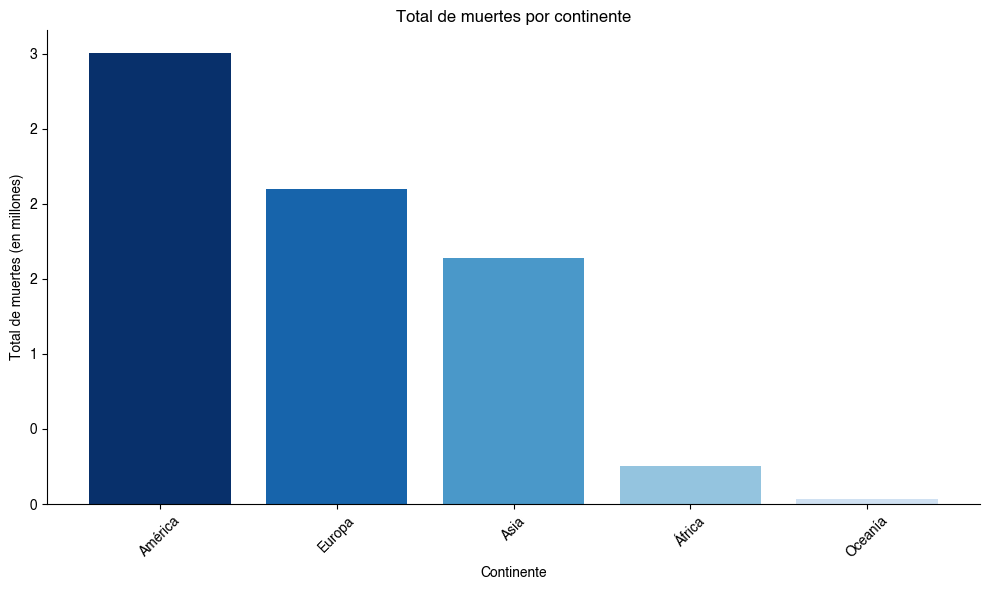

In [136]:
continentes = deaths_by_continent['Continente']
muertes = deaths_by_continent['Total_deaths']

# Ordenar los datos de mayor a menor
sorted_indices = np.argsort(muertes)[::-1]
continentes = continentes[sorted_indices]
muertes = muertes[sorted_indices]

colors = plt.cm.Blues(np.linspace(1, 0.2, len(muertes))) 

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(continentes, muertes, color=colors)

plt.xlabel('Continente')
plt.ylabel('Total de muertes (en millones)')
plt.title('Total de muertes por continente')
plt.xticks(rotation=45)  

plt.ticklabel_format(style='plain', axis='y')  
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x / 1e6))) 

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 7.1  ¿Cuál continente ha experimentado el mayor número de muertes debido al COVID-19?

##### América es el continente que ha experimentado el mayor número de muertes debido al COVID-19, lo que sugiere que ha enfrentado mayores desafíos en la gestión de la pandemia en comparación con otros continentes. En contraste, África, a pesar de tener el mayor número de países, ha registrado menos muertes. Esto puede atribuirse a varios factores, como la juventud de la población africana y la limitada capacidad para realizar pruebas de detección debido a recursos económicos limitados. Europa, con un sistema de salud más robusto, experimentó un aumento significativo de casos debido al incumplimiento temprano de las medidas preventivas, aunque no alcanzó los niveles de América. Asia, donde se originó el virus, ha presentado inconsistencias en los datos reportados por lo podrían variar los datos. Por último, Oceanía, con menos casos registrados, se destaca por tener una menor densidad poblacional y una mayor expectativa de vida.

# 8. Conlusiones

##### El Salvador, a pesar de formar parte del continente americano, ha destacado por tener uno de los menores números de casos confirmados y fatalidades relacionadas con el COVID-19. Este éxito se atribuye al manejo eficiente de las medidas sanitarias y de prevención implementadas por el gobierno. Además, el país fue uno de los primeros en América Latina en asegurar y administrar dosis de vacunas contra el virus, lo que contribuyó significativamente a la protección de su población. El cierre temprano de aeropuertos y la menor densidad demográfica en comparación con otros países también han sido factores determinantes en la contención del virus en El Salvador.